In [194]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
%matplotlib inline

In [195]:
class DataPlotter:
    def __init__(self, dataset) -> None:
        self.dataset = dataset

    def get_all_features_observed(self):
        x_train_observed = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        return x_train_observed.columns

    def get_all_features_estimated(self):
        x_train_estimated = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        return x_train_estimated.columns
    
    def get_correlation(self, df, feature):
        with np.errstate(divide='ignore', invalid='ignore'):
            correlation = df[feature].corr(df['pv_measurement'])
            if np.isnan(correlation) or np.isinf(correlation):
                correlation = 0.0  # Handle the case when correlation is NaN or Inf
        return correlation
    
    def plot_feature_against_y(self, feature, observed, plot, hour=None, month=None):
        if observed:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_observed.parquet')
        else:
            y_train = pd.read_parquet(self.dataset + '/train_targets.parquet')
            x_train = pd.read_parquet(self.dataset + '/X_train_estimated.parquet')
        
        # Convert 'time' and 'date_forecast' columns to datetime format
        y_train['time'] = pd.to_datetime(y_train['time'])
        x_train['date_forecast'] = pd.to_datetime(x_train['date_forecast'])

        if (hour and month) is not None:
            y_train_at_hour_and_month = y_train[
                (y_train['time'].dt.hour == hour) & (y_train['time'].dt.month == month)
            ]
            x_train_at_hour_and_month = x_train[
                (x_train['date_forecast'].dt.hour == hour) & (x_train['date_forecast'].dt.month == month)
            ]
            merged_df = pd.merge(
                y_train_at_hour_and_month, x_train_at_hour_and_month,
                left_on='time', right_on='date_forecast'
            )
        elif hour is not None and month is None:
            y_train_at_hour = y_train[y_train['time'].dt.hour == hour]
            x_train_at_hour = x_train[x_train['date_forecast'].dt.hour == hour]
            merged_df = pd.merge(
                y_train_at_hour, x_train_at_hour, left_on='time', right_on='date_forecast'
            )
        elif month is not None and hour is None:
            y_train_at_month = y_train[y_train['time'].dt.month == month]
            x_train_at_month = x_train[x_train['date_forecast'].dt.month == month]
            merged_df = pd.merge(
                y_train_at_month, x_train_at_month, left_on='time', right_on='date_forecast'
            )
        elif not month and not hour:
            merged_df = pd.merge(y_train , x_train, left_on='time', right_on='date_forecast')
        
        merged_df = merged_df.dropna(subset=[feature, 'pv_measurement'])
        corr = self.get_correlation(df = merged_df, feature=feature)

        if plot:
            plt.figure(figsize=(6, 4))
            plt.scatter(merged_df[feature], merged_df['pv_measurement'], alpha=1)
            plt.xlabel(feature)
            plt.ylabel('PV Measurement')
            plt.title(feature + ' vs PV Measurement')
            plt.grid(True)
            plt.show()

        if math.isnan(corr):
            return 0
        
        return corr
    
    def plot_feature_analysis(self, observed, plot, feature=None, hour=None, month=None):
        if observed:
            if feature:
                print(feature + " FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM OBSERVED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_observed():
                    self.plot_feature_against_y(feature, observed=True, plot=plot, hour=hour, month=month)
        else:
            if feature:
                print(feature + " FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                corr = self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)
                return corr
            else:
                print("ALL FEATURES PLOTTED FROM ESTIMATED DATASET FROM LOCATION " + self.dataset + ".")
                for feature in self.get_all_features_estimated():
                    self.plot_feature_against_y(feature, observed=False, plot=plot, hour=hour, month = month)

## Plot your desired feature against a spesific month and hour

- You can choose hour and month to be None to get a more general view of the data
- Note that sometimes there few datapoints when having to much spesifisty, hence the correlation might be "skewed".

visibility:m FROM ESTIMATED DATASET FROM LOCATION C.


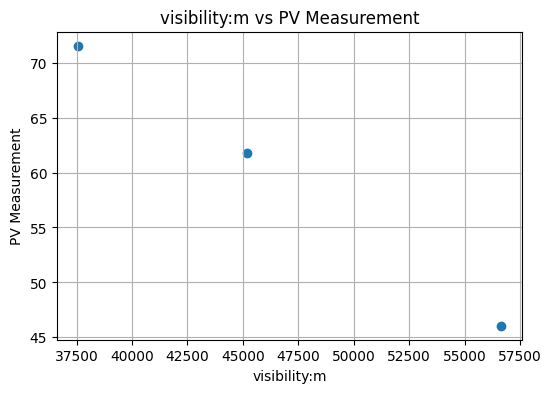

Correlation is -0.9998387063


In [200]:
# Choose what dataset you want your values from (observed = False gets the estimated dataset).
# Spesify hour (example: 12) and/or month (example: 6). Either of them can be None.
# Choose your feature. If you spesify 'feature' to be None, then it will plot for ALL feautures.


dataset = 'C'
observed = False
hour = 14
month = 10
feature = 'visibility:m'

plotter = DataPlotter(dataset)

corr = plotter.plot_feature_analysis(observed=observed, plot=True, feature=feature, hour=hour, month=month)
if corr is not None:
    print("Correlation is", round(corr, 10))


In [201]:
# A class to aid the function below

class Observation:
    def __init__(self, feature, hour, month, corr) -> None:
        self.feature = feature
        self.hour = hour
        self.month = month
        self.corr = corr

# Sorting on Correlation

The code snippet below will go through all combinations of hours, months and feature and sort the different cases on correlation. The output is a csv file. Note that this will take about 4-5 min to run on an Apple silicon M1 processor. 

- When running you might encounter the error "RuntimeWarning: Degrees of freedom <= 0 for slice". This happens when data you're working with is insufficient to compute that statistic. One common scenario is when computing the variance or standard deviation of a dataset with a single value or no values.
    - This makes since for some cases there are not many data points.

In [ ]:
# ITERATE THROUGH ALL COMBINATIONS OF MONTHS AND HOURS FOR A CHOSEN LOCATION AND SORT ON CORRELATION
# CREATES .CSV FILE
# NOTE Takes a long time to run

dataset = 'C'
observed = False

########################################################################################################################
plotter = DataPlotter(dataset)

if observed: all_features = plotter.get_all_features_observed()
else: all_features = plotter.get_all_features_estimated()

hours = list(range(24))
months = list(range(1, 13))

observations = []
for feature in all_features:
    for hour in hours:
        for month in months:
            corr = plotter.plot_feature_against_y(feature=feature, observed=observed, plot=False, hour=hour, month=month)
            obsvervation = Observation(feature, hour, month, corr)
            observations.append(obsvervation)

sorted_observations = sorted(observations, key=lambda x: -abs(x.corr))

if observed: csv_filename = "sorted_feature_correlations_" + dataset + "_observed.csv"
else: csv_filename = "sorted_feature_correlations_" + dataset + "_estimated.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Feature', 'Hour', 'Month', 'Correlation'])

    for obs in sorted_observations:
        row_data = [obs.feature, obs.hour, obs.month, obs.corr]
        csv_writer.writerow(row_data)

print(f"CSV file '{csv_filename}' has been created.")

# Analysing the Correlation Data

We can see that the feature correlations vary a lot with different hours and months. This is natural since, for instance, there is no sun at night time. Notice that the correlation of many features are much higher when approaching summer months as well.

To analyse the correlation data we can look at the average correlation of each feature irregardles of the hour or month. Then we can look at the same with hour and month in mind. Hence we can extrapolate what feature seem to be important.

In [286]:
# Choose location and observed/estimated, then run the analysis

location = 'B'
observed = True

if observed: csv_filename = location + "/sorted_feature_correlations_" + location + "_observed.csv"
else: csv_filename = location + "/sorted_feature_correlations_" + location + "_estimated.csv"

df = pd.read_csv(csv_filename)

When looking at the average correlation of the features (ranked in the absolute value of the correlation) for all the locations we can state the following:

Location A:
- **direct_rad_1h:J** has the highest correlation for observed/estimated
 - Other top correlated features seem to be **effective_cloud_cover:p**, **total_cloud_cover:p**, **visibility:m** etc.

Location B:
 - **direct_rad:W** and **direct_rad_1h:J** are on top
 - **sun_elevation:d** has some higher importance here

 Location C:
  - **direct_rad_1h:J** and **direct_rad_1h:J** are on top

  Note that cloud cover has a negative correlation

In [287]:
avg_correlation = df.groupby('Feature')['Correlation'].mean().reset_index()

avg_correlation.sort_values(by='Correlation', key=abs, ascending=False).head(10)

Feature  Correlation
11                 direct_rad:W     0.233218
12              direct_rad_1h:J     0.229888
37              sun_elevation:d     0.171454
13      effective_cloud_cover:p    -0.166713
3         clear_sky_energy_1h:J     0.153714
4               clear_sky_rad:W     0.150085
41                 visibility:m     0.137576
29  relative_humidity_1000hPa:p    -0.133272
40          total_cloud_cover:p    -0.133161
5              cloud_base_agl:m     0.131772

## Now including hour and month in our analysis

**NOTE:** Some correlations are 1 or -1. This is because some instances might have only one or two datapoints leading to an inaccurate estimate of the correlation.

- We can look at the top correlated features for every month then for every hour.

In [288]:
# Outputs top features with the highest correlations when INCLUDING HOUR AND MONTH

df = pd.read_csv(csv_filename)
df.head(10)

Feature  Hour  Month  Correlation
0  clear_sky_energy_1h:J     8     11     0.830680
1        clear_sky_rad:W     8     11     0.823640
2       is_in_shadow:idx     8     11    -0.811408
3        direct_rad_1h:J     8     10     0.792964
4       diffuse_rad_1h:J     8     11     0.791008
5          diffuse_rad:W     8     11     0.790991
6           direct_rad:W     8     10     0.787655
7  clear_sky_energy_1h:J    10     11     0.785969
8          diffuse_rad:W    13     11     0.784049
9        clear_sky_rad:W    10     11     0.783330

### What does the every month analysis tell us?

- When analysing the observed data for all three locations the summer month seem to be more reliant on radiation. Whilst in the winter months features like **absolute_humidity_2m:gm3** and **clear_sky_energy_1h:J** takes over (locations B and C, but not A).
- The analysis seems to break down for the estimated datasets due to the skewed correlations, because of the lack of sufficient data.

In [289]:
# The most highly correlated value for EVERY MONTH

df['Month'] = pd.Categorical(df['Month'], categories=df['Month'].unique(), ordered=True)
max_corr_rows = pd.DataFrame()

for month in df['Month'].cat.categories:
    monthly_data = df[df['Month'] == month]
    
    max_corr_idx = monthly_data['Correlation'].idxmax()
    
    max_corr_rows = pd.concat([max_corr_rows, df.loc[[max_corr_idx]]], ignore_index=True)

# Sort max_corr_rows by the 'Month' column
max_corr_rows['Month'] = max_corr_rows['Month'].astype(int)  # Ensure 'Month' is an integer type for proper sorting
max_corr_rows.sort_values('Month', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows

Feature  Hour  Month  Correlation
0               direct_rad:W    14      1     0.503278
1   absolute_humidity_2m:gm3    15      2     0.557116
2               direct_rad:W     8      3     0.401765
3               direct_rad:W     7      4     0.751622
4               direct_rad:W     7      5     0.767097
5               direct_rad:W     9      6     0.779392
6            direct_rad_1h:J     5      7     0.705664
7              sun_azimuth:d    16      8     0.621222
8            direct_rad_1h:J     6      9     0.733117
9            direct_rad_1h:J     8     10     0.792964
10     clear_sky_energy_1h:J     8     11     0.830680
11           clear_sky_rad:W     9     12     0.433177

### What does the every hour analysis tell us?

- At nighttime these feature appear more often:
    - **date_forecast**
    - **visibility:m**
    - **sfc_pressure:hPa** 
------------------------------------
- At daytime these features dominate:
    - **Radiation (direct early in the morning, then diffuse radiontion in the afternoon)**
    - **clear_sky_energy_1h:J**

In [291]:
# The most highly correlated value for EVERY HOUR

max_corr_rows = pd.DataFrame()

for hour in range(0, 24):  
    hourly_data = df[df['Hour'] == hour]
    
    if not hourly_data.empty:  
        max_corr_idx = hourly_data['Correlation'].idxmax()
        max_corr_rows = pd.concat([max_corr_rows, df.loc[[max_corr_idx]]], ignore_index=True)

max_corr_rows.sort_values('Hour', inplace=True)
max_corr_rows.reset_index(drop=True, inplace=True)

max_corr_rows


Feature  Hour Month  Correlation
0           date_forecast     0     9     0.585378
1           date_forecast     1     9     0.575023
2           date_forecast     2     9     0.575023
3           date_forecast     3     9     0.575023
4            direct_rad:W     4     5     0.666494
5         direct_rad_1h:J     5     6     0.709759
6         direct_rad_1h:J     6     9     0.733117
7        diffuse_rad_1h:J     7    10     0.770198
8   clear_sky_energy_1h:J     8    11     0.830680
9            direct_rad:W     9     6     0.779392
10  clear_sky_energy_1h:J    10    11     0.785969
11  clear_sky_energy_1h:J    11    11     0.748254
12           direct_rad:W    12     6     0.734934
13          diffuse_rad:W    13    11     0.784049
14           direct_rad:W    14     6     0.753942
15        clear_sky_rad:W    15    10     0.709678
16        direct_rad_1h:J    16     6     0.687194
17          sun_azimuth:d    17     4     0.621118
18          date_forecast    18     9     0.552941
19          date_forecast    19     9     0.555957
20          date_forecast    20     9     0.555957
21          date_forecast    21     9     0.555957
22          date_forecast    22     9     0.545367
23          date_forecast    23     9     0.567336

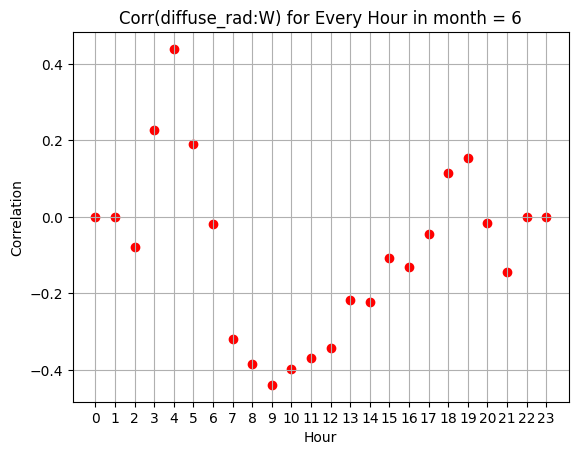

In [262]:
# Plot a the correlation of a feature for a spesific month for every hour
# Choose month and feature

month = 6
feature = 'diffuse_rad:W'

filtered_data = df[(df['Feature'] == feature) & (df['Month'] == month)]

# Creating a scatter plot of the correlation values for each hour.
plt.scatter(filtered_data['Hour'], filtered_data['Correlation'], color='red')
plt.xticks(range(0, 24))  
plt.title('Corr(' + feature + ') for Every Hour in month = ' + str(month))
plt.xlabel('Hour')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


# Lets do some Exploratory Analysis

Let us examine the data more carefully using pandas.

In [ ]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

## Differing times for each location

- Each location begins to record at a different date, although they all end at the same date. 
- Another thing of notice is that location B seems to start its readings the earliest, then comes A and C at least with quite a significant margin.

train_a head:


time  pv_measurement
0 2019-06-02 22:00:00             0.0
1 2019-06-02 23:00:00             0.0
2 2019-06-03 00:00:00             0.0

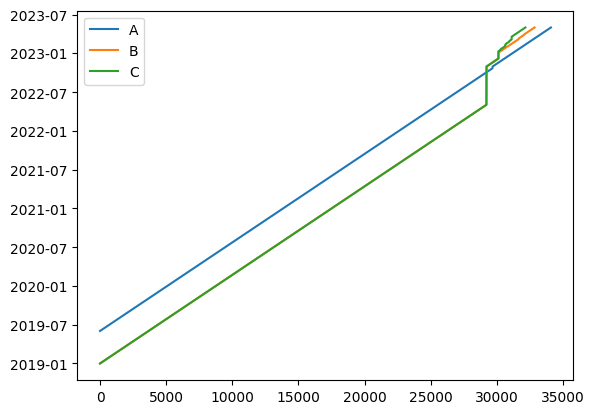

In [ ]:
train_a['time'].plot(label="A")
train_b['time'].plot(label="B")
train_c['time'].plot(label="C")
plt.legend()

print("train_a head:")
train_a.head(3)

## How about plotting pv measurment against time for all three locations?

Thing of notice:
- Location B and C has missing datapoints at some point
- The amplitude of the readings from location A are much higher than the other two locations.
    - This could happen if for example location A has more solar pannels
- Possible solutions could be to use min-max scaling

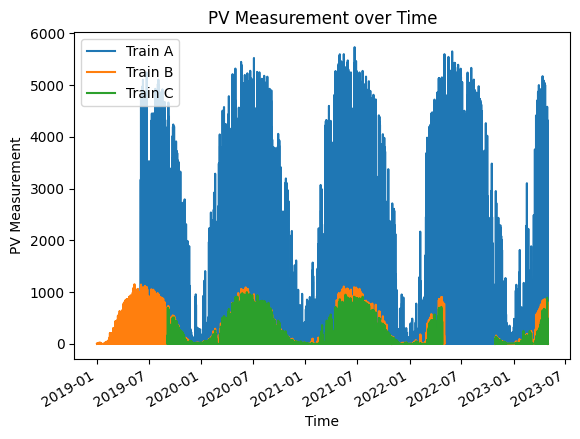

In [ ]:
fig, ax = plt.subplots()

train_a.plot(x='time', y='pv_measurement', ax=ax, label='Train A')
train_b.plot(x='time', y='pv_measurement', ax=ax, label='Train B')
train_c.plot(x='time', y='pv_measurement', ax=ax, label='Train C')

ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()

plt.show()

### An issue with data from location B

- There is a gap in the data around 2020
 - This might be due to some technical issues with the measuring equipment

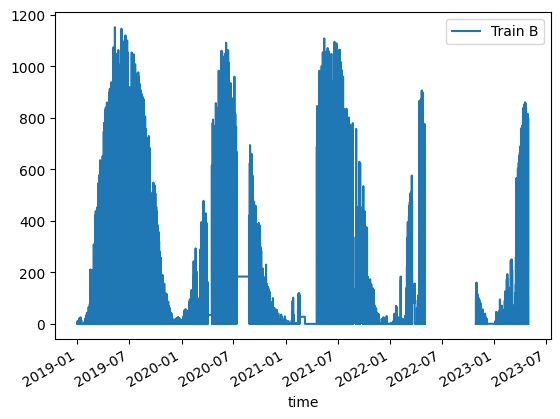

In [ ]:
train_b.plot(x='time', y='pv_measurement', label='Train B')
ax.set_xlabel('Time')
ax.set_ylabel('PV Measurement')
ax.set_title('PV Measurement over Time')
ax.legend()
plt.show()

## Let us examin both the observed and estimated dataset for all the locations starting with A

We will examine 
- Datashapes
- Datatypes
- Columns
- NaN values
- Some plots
- A correlation matrix

In [ ]:
X_train_observed_a.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-06-02 22:00:00                       7.7                1.230   
1 2019-06-02 22:15:00                       7.7                1.229   
2 2019-06-02 22:30:00                       7.7                1.228   
3 2019-06-02 22:45:00                       7.7                1.226   
4 2019-06-02 23:00:00                       7.7                1.225   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1744.900024                    0.0              0.0   
1           1734.000000                    0.0              0.0   
2           1723.500000                    0.0              0.0   
3           1713.400024                    0.0              0.0   
4           1703.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1744.900024              0.0      280.299988            0.0  ...   
1       1734.000000              0.0      280.299988            0.0  ...   
2       1723.500000              0.0      280.299988            0.0  ...   
3       1713.400024              0.0      280.299988            0.0  ...   
4       1703.599976              0.0      280.299988            0.0  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     342.834015           -3.202                             0.0   
1     346.294006           -3.650                             0.0   
2     349.768005           -3.998                             0.0   
3     353.251007           -4.247                             0.0   
4     356.742004           -4.393                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   285.899994                100.0  39640.101562                3.7   
1   286.100006                100.0  40123.898438                3.6   
2   286.299988                100.0  40628.300781                3.6   
3   286.600006                100.0  41153.601562                3.5   
4   286.799988                100.0  41699.898438                3.5   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -3.6                 -0.8                     -0.0  
1                 -3.6                 -0.6                     -0.0  
2                 -3.6                 -0.4                     -0.0  
3                 -3.5                 -0.2                     -0.0  
4                 -3.5                  0.0                     -0.0  

[5 rows x 46 columns]

In [ ]:
X_train_estimated_a.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.3   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.233           1425.099976                    0.0   
1                1.233           2085.899902                    0.0   
2                1.233           2746.600098                    0.0   
3                1.233           3407.399902                    0.0   
4                1.233           4068.199951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1211.699951              1.0      281.399994  ...   
1              0.0       1560.500000              1.0      281.299988  ...   
2              0.0       1909.400024              1.0      281.200012  ...   
3              0.0       2258.199951              1.0      281.200012  ...   
4              0.0       2607.000000              1.0      281.100006  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.799011       -38.466999                             0.0   
1     345.451996       -38.955002                             0.0   
2     350.153015       -39.310001                             0.0   
3     354.886993       -39.528999                             0.0   
4     359.638000       -39.609001                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   284.700012                100.0  29429.699219                0.8   
1   284.700012                100.0  23604.099609                0.7   
2   284.700012                100.0  17799.800781                0.7   
3   284.600006                100.0  12016.500000                0.6   
4   284.600006                100.0   6254.399902                0.6   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.4                  0.7                     -0.0  
1                 -0.4                  0.7                     -0.0  
2                 -0.3                  0.6                     -0.0  
3                 -0.2                  0.6                     -0.0  
4                 -0.1                  0.6                     -0.0  

[5 rows x 47 columns]

In [ ]:
X_train_estimated_a.shape, X_train_observed_a.shape


((17576, 47), (118669, 46))

In [ ]:
X_train_observed_a.dtypes

date_forecast                     datetime64[us]
absolute_humidity_2m:gm3                 float32
air_density_2m:kgm3                      float32
ceiling_height_agl:m                     float32
clear_sky_energy_1h:J                    float32
clear_sky_rad:W                          float32
cloud_base_agl:m                         float32
dew_or_rime:idx                          float32
dew_point_2m:K                           float32
diffuse_rad:W                            float32
diffuse_rad_1h:J                         float32
direct_rad:W                             float32
direct_rad_1h:J                          float32
effective_cloud_cover:p                  float32
elevation:m                              float32
fresh_snow_12h:cm                        float32
fresh_snow_1h:cm                         float32
fresh_snow_24h:cm                        float32
fresh_snow_3h:cm                         float32
fresh_snow_6h:cm                         float32
is_day:idx          

In [ ]:
X_train_observed_a.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [ ]:
X_train_observed_a.isna().sum()

date_forecast                          0
absolute_humidity_2m:gm3               0
air_density_2m:kgm3                    0
ceiling_height_agl:m               22247
clear_sky_energy_1h:J                  0
clear_sky_rad:W                        0
cloud_base_agl:m                    8066
dew_or_rime:idx                        0
dew_point_2m:K                         0
diffuse_rad:W                          0
diffuse_rad_1h:J                       0
direct_rad:W                           0
direct_rad_1h:J                        0
effective_cloud_cover:p                0
elevation:m                            0
fresh_snow_12h:cm                      0
fresh_snow_1h:cm                       0
fresh_snow_24h:cm                      0
fresh_snow_3h:cm                       0
fresh_snow_6h:cm                       0
is_day:idx                             0
is_in_shadow:idx                       0
msl_pressure:hPa                       0
precip_5min:mm                         0
precip_type_5min

In [ ]:
X_train_estimated_a.isna().sum()

date_calc                             0
date_forecast                         0
absolute_humidity_2m:gm3              0
air_density_2m:kgm3                   0
ceiling_height_agl:m               3919
clear_sky_energy_1h:J                 0
clear_sky_rad:W                       0
cloud_base_agl:m                   2094
dew_or_rime:idx                       0
dew_point_2m:K                        0
diffuse_rad:W                         0
diffuse_rad_1h:J                      0
direct_rad:W                          0
direct_rad_1h:J                       0
effective_cloud_cover:p               0
elevation:m                           0
fresh_snow_12h:cm                     0
fresh_snow_1h:cm                      0
fresh_snow_24h:cm                     0
fresh_snow_3h:cm                      0
fresh_snow_6h:cm                      0
is_day:idx                            0
is_in_shadow:idx                      0
msl_pressure:hPa                      0
precip_5min:mm                        0


In [ ]:
X_train_observed_a.loc[X_train_observed_a.duplicated()]

Empty DataFrame
Columns: [date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
Index: []

[0 rows x 46 columns]

In [ ]:
X_train_estimated_a.loc[X_train_estimated_a.duplicated()]

Empty DataFrame
Columns: [date_calc, date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
Index: []

[0 rows x 47 columns]

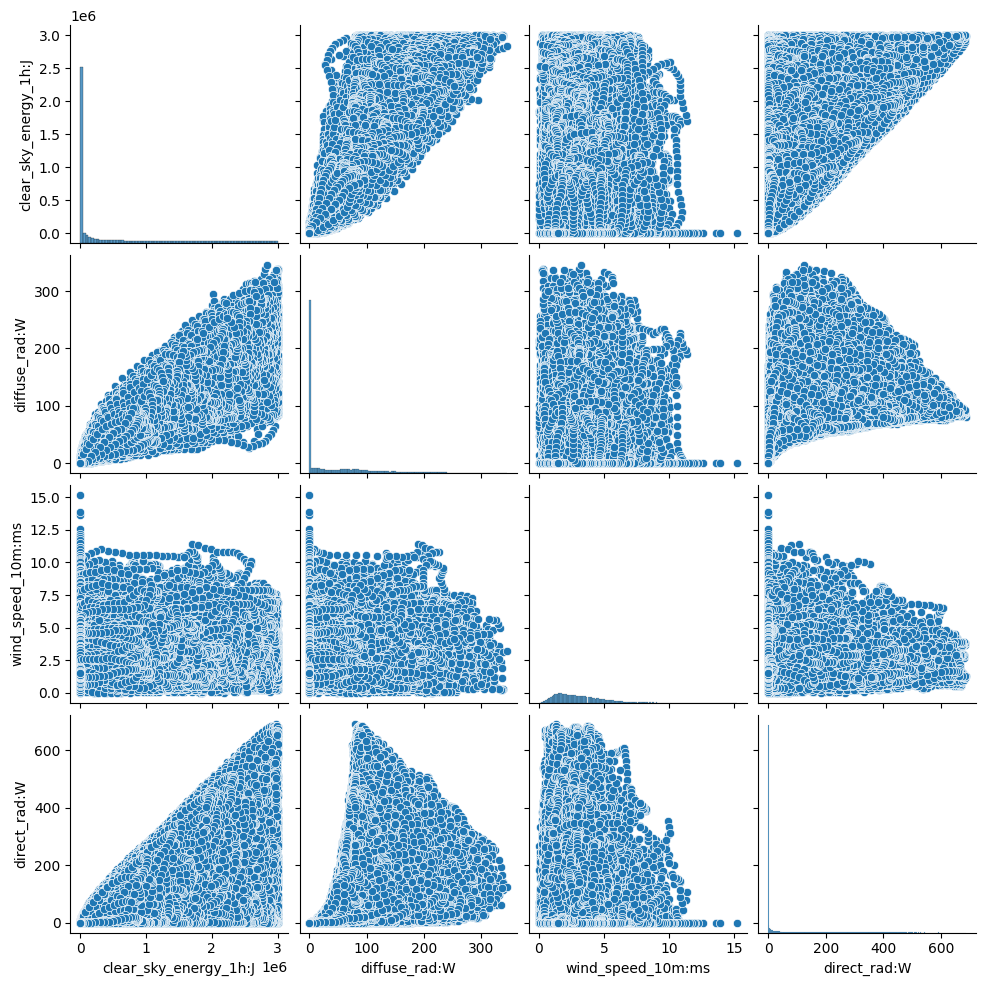

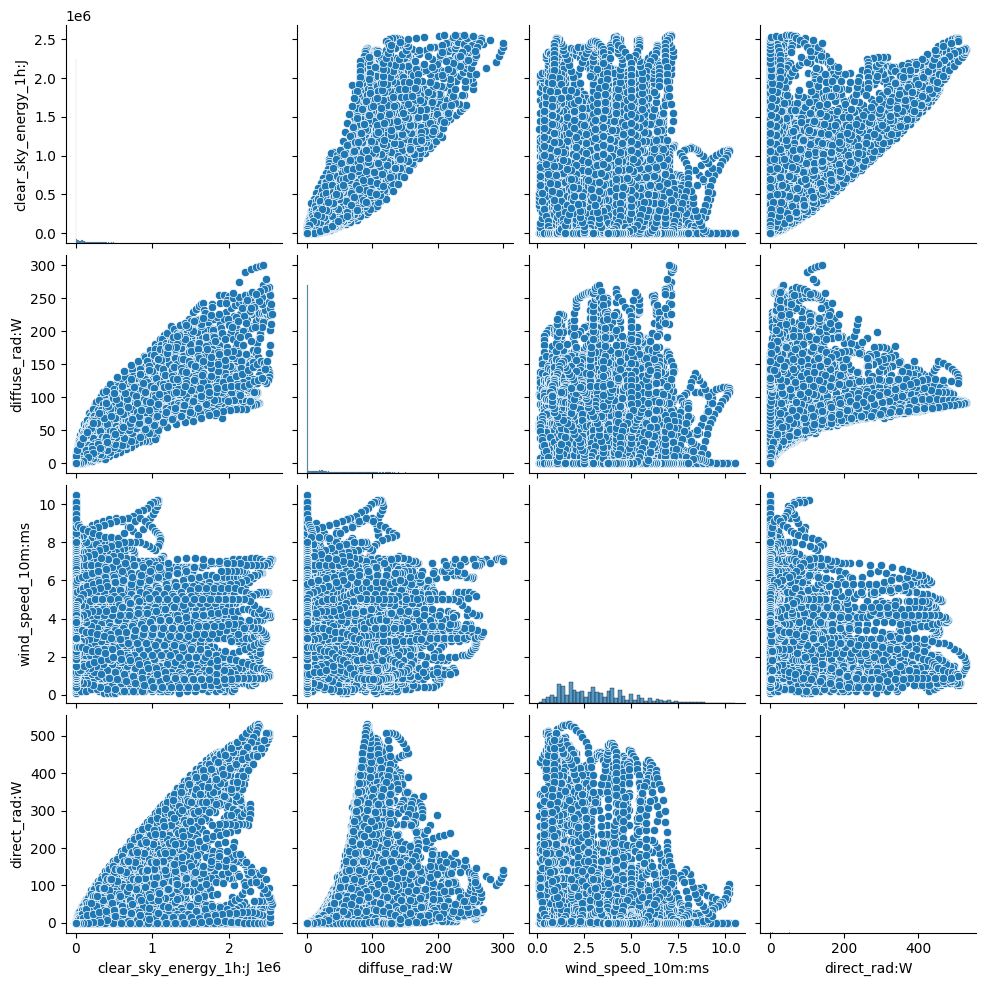

In [ ]:
sns.pairplot(X_train_observed_a, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W'])
sns.pairplot(X_train_estimated_a, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W'])
plt.show()

In [ ]:
df_corr = X_train_observed_a[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.911178   
diffuse_rad:W                       0.911178       1.000000   
wind_speed_10m:ms                   0.013025      -0.004529   
direct_rad:W                        0.719660       0.555213   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.013025      0.719660  
diffuse_rad:W                  -0.004529      0.555213  
wind_speed_10m:ms               1.000000     -0.095310  
direct_rad:W                   -0.095310      1.000000

In [ ]:
df_corr = X_train_estimated_a[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.904585   
diffuse_rad:W                       0.904585       1.000000   
wind_speed_10m:ms                   0.035973       0.066920   
direct_rad:W                        0.756767       0.550829   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.035973      0.756767  
diffuse_rad:W                   0.066920      0.550829  
wind_speed_10m:ms               1.000000     -0.068388  
direct_rad:W                   -0.068388      1.000000

## Now let us explore location B

In [ ]:
X_train_observed_b.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-01-01 00:00:00                       5.6                1.239   
1 2019-01-01 00:15:00                       5.6                1.239   
2 2019-01-01 00:30:00                       5.5                1.240   
3 2019-01-01 00:45:00                       5.4                1.241   
4 2019-01-01 01:00:00                       5.4                1.241   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1226.400024                    0.0              0.0   
1           1209.300049                    0.0              0.0   
2           1192.099976                    0.0              0.0   
3           1174.900024                    0.0              0.0   
4           1157.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1226.400024              0.0      275.399994            0.0  ...   
1       1209.300049              0.0      275.200012            0.0  ...   
2       1192.099976              0.0      275.100006            0.0  ...   
3       1174.900024              0.0      274.899994            0.0  ...   
4       1157.599976              0.0      274.700012            0.0  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0      12.985000       -49.139999                             0.0   
1      18.205999       -48.688000                             0.0   
2      23.339001       -48.091000                             0.0   
3      28.367001       -47.358002                             0.0   
4      33.275002       -46.497002                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   278.399994            73.900002  19275.900391                2.5   
1   278.299988            83.800003  17638.000000                2.7   
2   278.200012            91.199997  16008.799805                2.9   
3   278.100006            96.400002  14388.500000                3.1   
4   278.000000            99.400002  12777.299805                3.4   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                  1.1                  2.2                     -0.0  
1                  1.2                  2.4                     -0.0  
2                  1.2                  2.7                     -0.0  
3                  1.2                  2.9                     -0.0  
4                  1.3                  3.1                     -0.0  

[5 rows x 46 columns]

In [ ]:
X_train_estimated_b.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.4   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.4   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.5   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.233           1425.099976                    0.0   
1                1.233           2086.000000                    0.0   
2                1.232           2746.899902                    0.0   
3                1.232           3407.800049                    0.0   
4                1.231           4068.699951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1211.900024              1.0      281.399994  ...   
1              0.0       1562.500000              1.0      281.399994  ...   
2              0.0       1913.099976              1.0      281.500000  ...   
3              0.0       2263.699951              1.0      281.500000  ...   
4              0.0       2614.300049              1.0      281.500000  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.799988       -38.466000                             0.0   
1     345.453003       -38.955002                             0.0   
2     350.153992       -39.310001                             0.0   
3     354.888000       -39.528999                             0.0   
4     359.639008       -39.609001                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   284.700012                100.0  29393.500000                0.8   
1   284.700012                100.0  23576.500000                0.7   
2   284.700012                100.0  17780.300781                0.7   
3   284.600006                100.0  12005.099609                0.6   
4   284.600006                100.0   6250.600098                0.6   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.4                  0.7                     -0.0  
1                 -0.4                  0.6                     -0.0  
2                 -0.3                  0.6                     -0.0  
3                 -0.2                  0.6                     -0.0  
4                 -0.1                  0.6                     -0.0  

[5 rows x 47 columns]

In [ ]:
X_train_estimated_b.shape, X_train_observed_b.shape

((17576, 47), (116929, 46))

In [ ]:
X_train_observed_b.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [ ]:
X_train_estimated_b.columns

Index(['date_calc', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_spe

In [ ]:
X_train_observed_b.loc[X_train_observed_b.duplicated()], X_train_estimated_b.loc[X_train_estimated_b.duplicated()]

(Empty DataFrame
 Columns: [date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
 Index: []
 
 [0 rows x 46 columns],
 Empty DataFrame
 Columns: [date_calc, date_forecast, absolute_humidity_2m:gm3, a

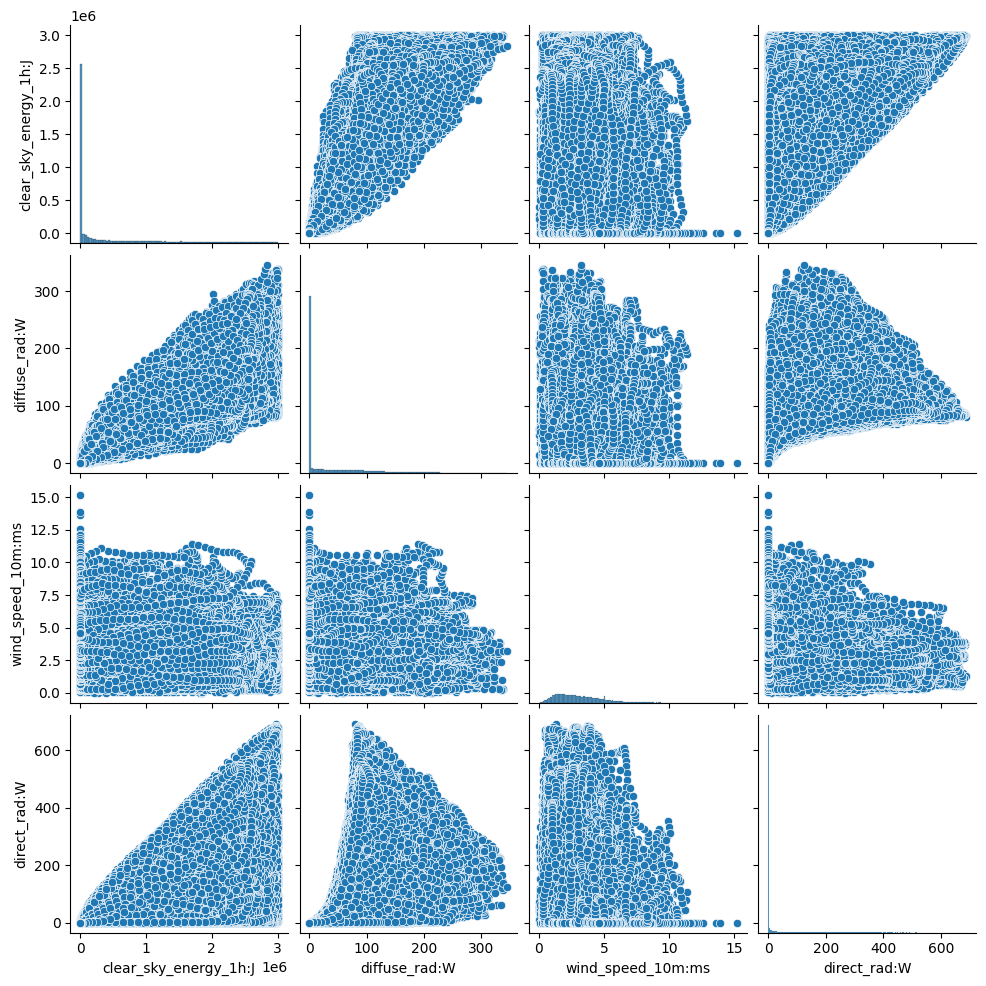

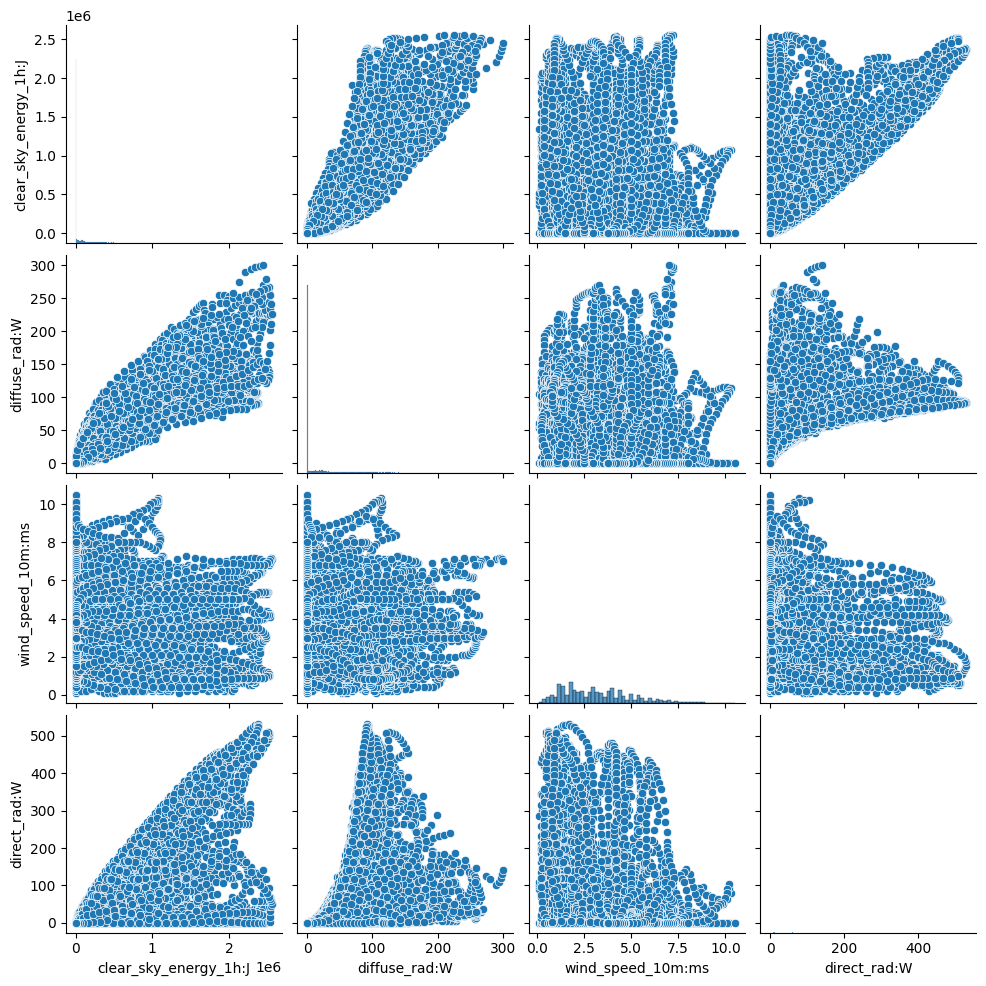

In [ ]:
sns.pairplot(X_train_observed_b, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
sns.pairplot(X_train_estimated_b, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
plt.show()

In [292]:
df_corr = X_train_observed_b[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.910521   
diffuse_rad:W                       0.910521       1.000000   
wind_speed_10m:ms                   0.004644      -0.008523   
direct_rad:W                        0.738171       0.572789   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.004644      0.738171  
diffuse_rad:W                  -0.008523      0.572789  
wind_speed_10m:ms               1.000000     -0.102084  
direct_rad:W                   -0.102084      1.000000

In [293]:
df_corr = X_train_estimated_b[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.904608   
diffuse_rad:W                       0.904608       1.000000   
wind_speed_10m:ms                   0.036064       0.067110   
direct_rad:W                        0.756784       0.550859   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.036064      0.756784  
diffuse_rad:W                   0.067110      0.550859  
wind_speed_10m:ms               1.000000     -0.068302  
direct_rad:W                   -0.068302      1.000000

## Now for location C

In [294]:
X_train_observed_c.head()

date_forecast  absolute_humidity_2m:gm3  air_density_2m:kgm3  \
0 2019-01-01 00:00:00                       5.6                1.240   
1 2019-01-01 00:15:00                       5.5                1.241   
2 2019-01-01 00:30:00                       5.4                1.241   
3 2019-01-01 00:45:00                       5.4                1.241   
4 2019-01-01 01:00:00                       5.3                1.241   

   ceiling_height_agl:m  clear_sky_energy_1h:J  clear_sky_rad:W  \
0           1153.599976                    0.0              0.0   
1           1137.900024                    0.0              0.0   
2           1122.199951                    0.0              0.0   
3           1106.400024                    0.0              0.0   
4           1090.599976                    0.0              0.0   

   cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  diffuse_rad:W  ...  \
0       1153.599976              1.0      275.200012            0.0  ...   
1       1137.900024              1.0      275.100006            0.0  ...   
2       1122.199951              1.0      274.899994            0.0  ...   
3       1106.400024              1.0      274.700012            0.0  ...   
4       1090.599976              1.0      274.500000            0.0  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0      12.989000       -49.178001                             0.0   
1      18.214001       -48.724998                             0.0   
2      23.351000       -48.127998                             0.0   
3      28.382000       -47.393002                             0.0   
4      33.292999       -46.529999                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   278.500000            68.500000  18220.400391                2.5   
1   278.399994            80.800003  17083.699219                2.8   
2   278.299988            89.900002  15940.900391                3.0   
3   278.200012            96.099998  14792.000000                3.3   
4   278.100006            99.400002  13637.299805                3.5   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                  1.1                  2.2                     -0.0  
1                  1.1                  2.5                     -0.0  
2                  1.1                  2.8                     -0.0  
3                  1.2                  3.0                     -0.0  
4                  1.2                  3.3                     -0.0  

[5 rows x 46 columns]

In [295]:
X_train_estimated_c.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.3   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.3   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.2   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.231           1427.400024                    0.0   
1                1.231           2089.000000                    0.0   
2                1.231           2750.500000                    0.0   
3                1.230           3412.100098                    0.0   
4                1.230           4073.699951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1215.800049              1.0      281.200012  ...   
1              0.0       1425.900024              1.0      281.200012  ...   
2              0.0       1636.099976              1.0      281.100006  ...   
3              0.0       1846.199951              1.0      281.100006  ...   
4              0.0       2056.399902              1.0      281.100006  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.785004       -38.502998                             0.0   
1     345.440002       -38.992001                             0.0   
2     350.144012       -39.348000                             0.0   
3     354.880005       -39.567001                             0.0   
4     359.634003       -39.647999                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   285.200012                100.0  34387.398438                1.2   
1   285.100006                100.0  27418.500000                1.2   
2   285.100006                100.0  20508.800781                1.2   
3   285.000000                100.0  13657.799805                1.2   
4   285.000000                100.0   6865.000000                1.2   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.3                  1.1                     -0.0  
1                 -0.2                  1.2                     -0.0  
2                 -0.1                  1.2                     -0.0  
3                 -0.0                  1.2                     -0.0  
4                  0.1                  1.2                     -0.0  

[5 rows x 47 columns]

In [297]:
X_train_observed_c.columns

Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [298]:
X_train_estimated_c.columns

Index(['date_calc', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_spe

In [299]:
X_train_observed_c.loc[X_train_observed_c.duplicated()], X_train_estimated_c.loc[X_train_estimated_c.duplicated()]

(Empty DataFrame
 Columns: [date_forecast, absolute_humidity_2m:gm3, air_density_2m:kgm3, ceiling_height_agl:m, clear_sky_energy_1h:J, clear_sky_rad:W, cloud_base_agl:m, dew_or_rime:idx, dew_point_2m:K, diffuse_rad:W, diffuse_rad_1h:J, direct_rad:W, direct_rad_1h:J, effective_cloud_cover:p, elevation:m, fresh_snow_12h:cm, fresh_snow_1h:cm, fresh_snow_24h:cm, fresh_snow_3h:cm, fresh_snow_6h:cm, is_day:idx, is_in_shadow:idx, msl_pressure:hPa, precip_5min:mm, precip_type_5min:idx, pressure_100m:hPa, pressure_50m:hPa, prob_rime:p, rain_water:kgm2, relative_humidity_1000hPa:p, sfc_pressure:hPa, snow_density:kgm3, snow_depth:cm, snow_drift:idx, snow_melt_10min:mm, snow_water:kgm2, sun_azimuth:d, sun_elevation:d, super_cooled_liquid_water:kgm2, t_1000hPa:K, total_cloud_cover:p, visibility:m, wind_speed_10m:ms, wind_speed_u_10m:ms, wind_speed_v_10m:ms, wind_speed_w_1000hPa:ms]
 Index: []
 
 [0 rows x 46 columns],
 Empty DataFrame
 Columns: [date_calc, date_forecast, absolute_humidity_2m:gm3, a

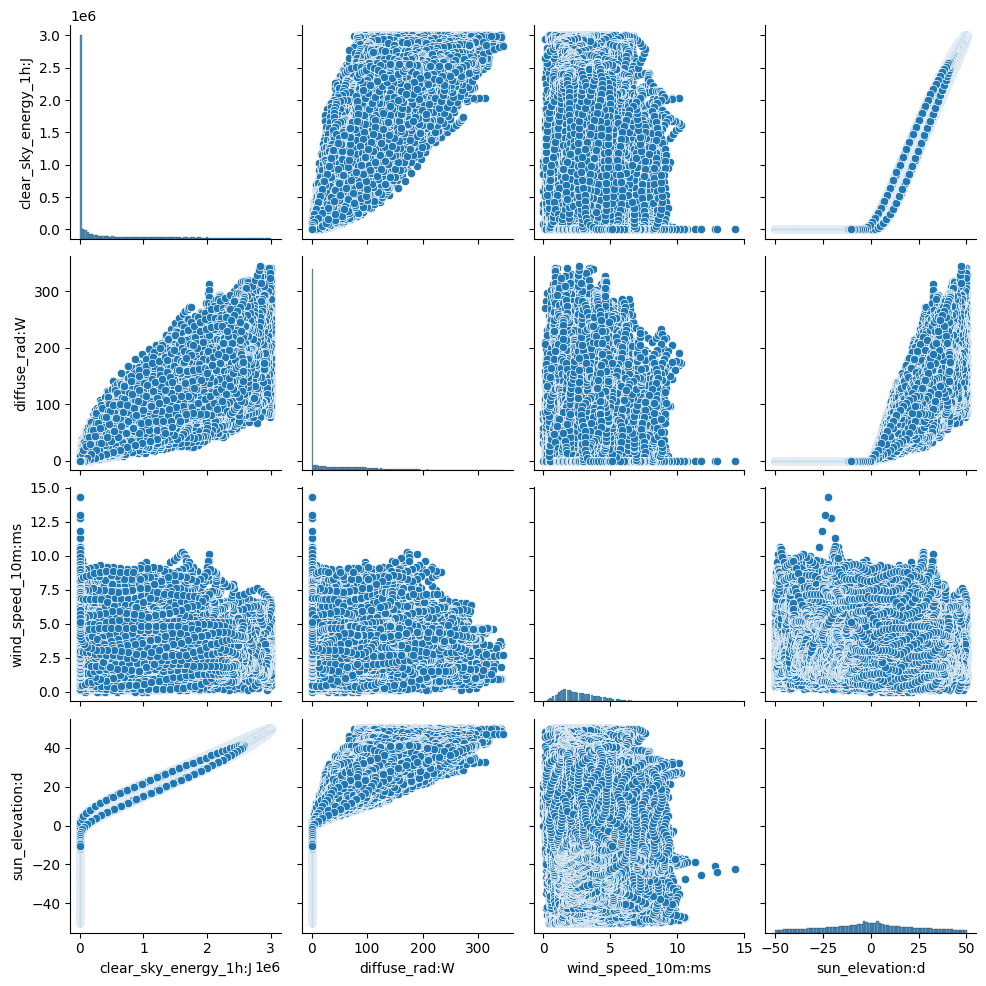

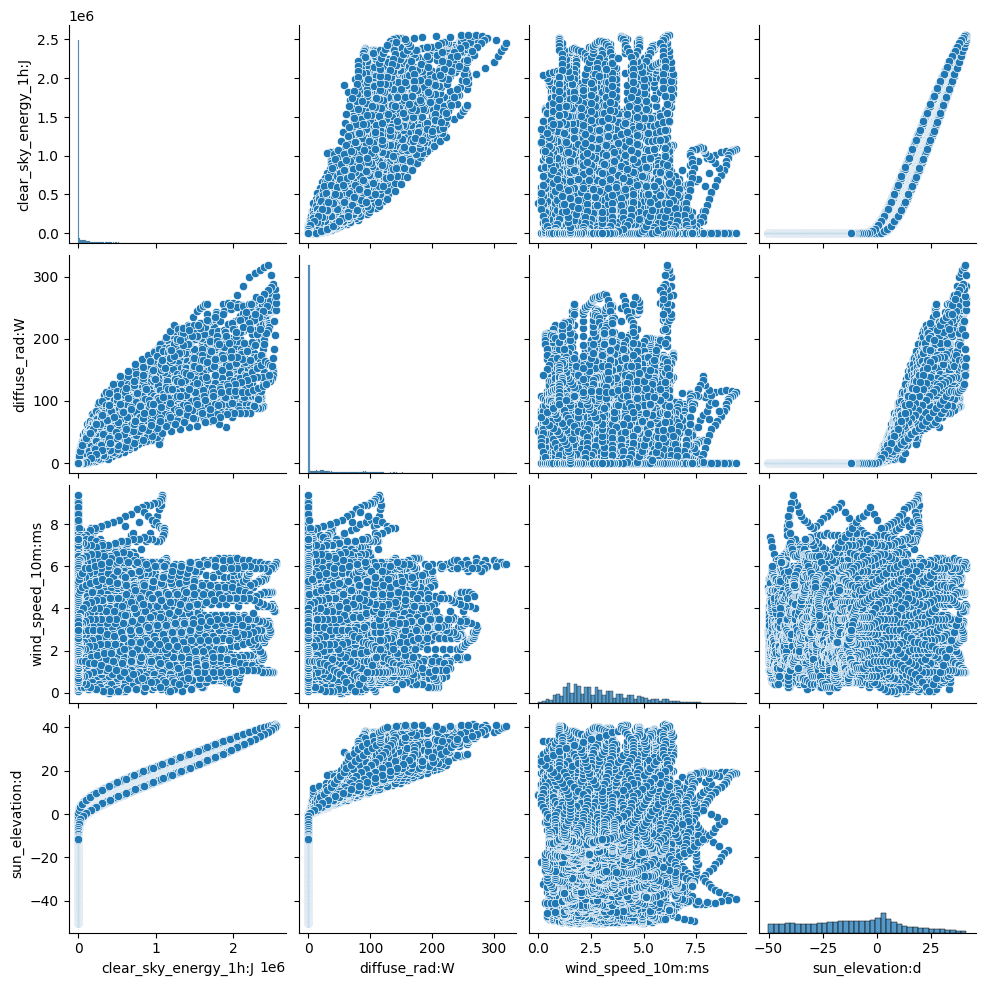

In [300]:
sns.pairplot(X_train_observed_c, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
sns.pairplot(X_train_estimated_c, vars = ['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'sun_elevation:d'])
plt.show()

In [301]:
df_corr = X_train_observed_c[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.908930   
diffuse_rad:W                       0.908930       1.000000   
wind_speed_10m:ms                   0.005627      -0.008779   
direct_rad:W                        0.731325       0.570156   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.005627      0.731325  
diffuse_rad:W                  -0.008779      0.570156  
wind_speed_10m:ms               1.000000     -0.088943  
direct_rad:W                   -0.088943      1.000000

In [302]:
df_corr = X_train_estimated_c[['clear_sky_energy_1h:J', 'diffuse_rad:W'
                                         ,'wind_speed_10m:ms', 'direct_rad:W']].dropna().corr()
df_corr

clear_sky_energy_1h:J  diffuse_rad:W  \
clear_sky_energy_1h:J               1.000000       0.902190   
diffuse_rad:W                       0.902190       1.000000   
wind_speed_10m:ms                   0.012182       0.041042   
direct_rad:W                        0.753555       0.547727   

                       wind_speed_10m:ms  direct_rad:W  
clear_sky_energy_1h:J           0.012182      0.753555  
diffuse_rad:W                   0.041042      0.547727  
wind_speed_10m:ms               1.000000     -0.093965  
direct_rad:W                   -0.093965      1.000000

# Conclusion

- None of the datasets have duplicates
- The dates have an incremeants in chuncks of 15 min. Note this might be important as we are asked to predict for every hour, we might possibly have to take the average for the four quarters in every hour.
- The correlations between some select features differ slighly for every location (might have to research this point even further) 

# Making a model with some predictors

Some good predictors to use are **XGBoost** and **Random Forest**. In this part of the notebook we will try to create model predictions using these libraries, whilst taking some of the knowledge attained from the previous parts to do some feature engineering if needed.